In [1]:
import os
import sys
from tqdm import tqdm

from matplotlib import pyplot as plt ##matplotlib.use('Agg') should call before pyplot for file printing

import tensorflow as tf
import numpy as np

from sklearn import mixture
import math
from tensorflow.python.framework import ops

import glob
import six
# import cPickle
from scipy.ndimage import imread
from scipy.misc import imresize
import scipy.io as sio
from collections import OrderedDict, defaultdict

from scipy import stats

from sklearn.decomposition import PCA


# Synthethic Data

In [2]:
class SynthDataset():   
    def __init__(self, x_dim=2, z_dim=2, num_clusters=4, seed=56):       
        np.random.seed(seed)
        
        self.x_dim = x_dim
        self.N = 10000
        self.true_z_dim = z_dim
        
        # generate synthetic data
        self.Xs = []
        for _ in range(0,num_clusters):
            cluster_mean = np.random.randn(self.true_z_dim) * 10 # to make them more spread
            A = np.random.randn(self.x_dim, self.true_z_dim) * 10
            X = np.dot(np.random.randn(int(self.N / num_clusters), self.true_z_dim) + cluster_mean, A.T) ##matrix mul
            self.Xs.append(X)
#         print(len(self.Xs[2]))
        X_raw = np.concatenate(self.Xs)
#         print("X_raw shape", X_raw.shape)
        self.X = (X_raw - X_raw.mean(0)) / (X_raw.std(0))
        self.N = self.X.shape[0]
        print ("Dataset shape", self.X.shape)
        
        
    def next_batch(self, batch_size):
        rand_idx = np.random.choice(range(self.N), size=(batch_size,), replace=False)
        return self.X[rand_idx]
    
    def visualize_data(self):
#         pca = PCA(n_components=2)
#         data = pca.fit_transform(self.X)
#         plt.scatter(data[:,0],data[:,1])
        plt.scatter(self.X[:,0], self.X[:,1])
        plt.show()
        return self.X

# Finding the good dataset

In [3]:
# 2 ----> 25, 30, 37, 101, 122,
# 3 ----> 1, 16, 43, 44, 57
# 4 ----> 1, (56,62,63),118, 142
# 5 ----> 24, 55, 77, 106
# 5 ----> 8, 25, 55, 77, 87, 92, 106
# for i in range(75, 100):
#     a = SynthDataset(seed=i)
#     data = a.visualize_data()

Dataset shape (10000, 2)


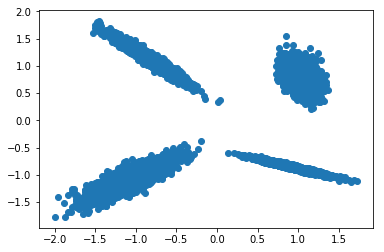

In [4]:
# 8, 25, 55, 77, 87, 92, 106
a = SynthDataset(seed=142)
data = a.visualize_data()

# GMM,KL_Div, JS Div 

In [5]:
def gmm_ms(X):
    aics = []
    n_components_range = range(1, 20)
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,covariance_type="full")
        gmm.fit(X)
        aics.append(gmm.aic(X))
    return np.array(aics)

def kl_div(p, q):
        eps = 1e-10
        p_safe = np.copy(p)
        p_safe[p_safe < eps] = eps
        q_safe = np.copy(q)
        q_safe[q_safe < eps] = eps
        return np.sum(p_safe * (np.log(p_safe) - np.log(q_safe)))
    
def js_div(p, q):
        m = (p + q) / 2.
        return (kl_div(p, m) + kl_div(q, m))/2.
    
def analyze_div(X_real, X_sample):
#     pca = PCA(n_components=2)
#     X_trans_real = pca.fit_transform(X_real)
#     X_trans_fake = pca.transform(X_sample)
    X_trans_real = np.copy(X_real)
    X_trans_fake = np.copy(X_sample)
    
    dx = 0.1
    dy = 0.1
    
    xmin1 = np.min(X_trans_real[:, 0]) - 3.0
    xmax1 = np.max(X_trans_real[:, 0]) + 3.0
    
    xmin2 = np.min(X_trans_real[:, 1]) - 3.0
    xmax2 = np.max(X_trans_real[:, 1]) + 3.0
    
    space = np.dstack(np.meshgrid(np.arange(xmin1,xmax1,dx), np.arange(xmin2,xmax2,dy))).reshape(-1, 2).T

    real_kde = stats.gaussian_kde(X_trans_real.T)
    real_density = real_kde(space) * dx * dy

    fake_kde = stats.gaussian_kde(X_trans_fake.T)
    fake_density = fake_kde(space) * dx * dy
    
    return js_div(real_density, fake_density), X_trans_real, X_trans_fake

# BGAN Network

In [6]:
class BGAN(object):
    def __init__(self, x_dim, z_dim, dataset_size, batch_size=64, prior_std=1.0, J=1, M=50, num_classes=1, alpha=0.01, lr=0.0002,
                 optimizer='adam', ml=False):
        self.batch_size = batch_size
        self.dataset_size = dataset_size
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.optimizer = optimizer
        self.prior_std = prior_std
        self.num_gen = J
        self.num_mcmc = M
        self.alpha = alpha
        self.lr = lr
        self.ml = ml
        if self.ml:
            assert self.num_gen*self.num_mcmc == 1, 'cannot have multiple generators in ml mode'
        self.weight_dims = OrderedDict([('g_h0_lin_w', (self.z_dim, 1000)),('g_h0_lin_b', (1000, )), ('g_lin_w',(1000, self.x_dim)),('g_lin_b',(self.x_dim,))]) ##changed the final x dimension
        self.sghmc_noise = {}
        self.noise_std = np.sqrt(2*self.alpha)
        for name, dim in self.weight_dims.items():
#             self.sghmc_noise[name] = tf.contrib.distributions.Normal(mu=0. , sigma=self.noise_std*tf.ones(self.weight_dims[name])) ##check normal distributions
            self.sghmc_noise[name] = tf.contrib.distributions.Normal(loc=0. , scale=self.noise_std*tf.ones(self.weight_dims[name])) ##check normal distributions

        self.K = num_classes
        self.build_bgan_graph()
        
    def linear(self, input_, output_size, scope=None, matrix=None, bias=None):
        shape = input_.get_shape().as_list()
        with tf.variable_scope(scope or 'Linear'):
            if matrix is None:
                matrix = tf.get_variable("Matrix", [shape[1], output_size], dtype=tf.float32, initializer=tf.random_normal_initializer(stddev=0.02))
            if bias is None:
                bias = tf.get_variable("bias", [output_size], initializer = tf.constant_initializer(0.0))
            return tf.matmul(input_, matrix) + bias
        
    def generator(self, z, gen_params):
        with tf.variable_scope('generator') as scope:
            h = self.linear(z, 1000, 'g_h0_lin', gen_params['g_h0_lin_w'], gen_params['g_h0_lin_b']) ##see when is matrix in linear is created i.e matrix=None
            h0 = tf.maximum(h, 0.2*h)
            self.x_ = self.linear(h0, self.x_dim, 'g_lin', gen_params['g_lin_w'], gen_params['g_lin_b'])
            return self.x_ ##check why its self.x_
        
    def discriminator(self, x, K, reuse=False):
        with tf.variable_scope('discriminator') as scope:
            if reuse:
                scope.reuse_variables()
            h = self.linear(x, 1000, 'd_lin_0')
            h0 = tf.maximum(h, 0.2*h)
            h1 = self.linear(h0, K, 'd_lin_1')
            return tf.nn.softmax(h1), h1 ##check the softmax layer
        
    def sampler(self, z, gen_params): ##why cant use directly
        with tf.variable_scope('generator') as scope:
            scope.reuse_variables()
            return self.generator(z, gen_params)
    
    def gen_prior(self, gen_params): ##why do we want scope here as generator from where dict is coming
        with tf.variable_scope('generator') as scope:
            prior_loss = 0.0
            for var in gen_params.values():
                nn = tf.divide(var, self.prior_std)
                prior_loss += tf.reduce_mean(tf.multiply(nn, nn))
        prior_loss /= self.dataset_size
        return prior_loss
    
    def gen_noise(self, gen_params): #sample ?? 
        with tf.variable_scope('generator') as scope:
            noise_loss = 0.0
            for name, var in gen_params.items():
                noise_loss += tf.reduce_sum(var * self.sghmc_noise[name].sample())
        noise_loss /= self.dataset_size
        return noise_loss
    
    def disc_prior(self):## why using self.d_vars
        with tf.variable_scope('discriminator') as scope:
            prior_loss = 0.0
            for var in self.d_vars:
                nn = tf.divide(var, self.prior_std)
                prior_loss += tf.reduce_mean(tf.multiply(nn, nn))
        prior_loss /= self.dataset_size
        return prior_loss
    
    def disc_noise(self): ## sample ? 
        with tf.variable_scope('discriminator') as scope:
            noise_loss = 0.0
            for var in self.d_vars:
#                 noise_ = tf.contrib.distributions.Normal(mu=0.0, sigma=self.noise_std*tf.ones(var.get_shape()))
                noise_ = tf.contrib.distributions.Normal(loc=0.0, scale=self.noise_std*tf.ones(var.get_shape()))
                noise_loss += tf.reduce_sum(var * noise_.sample())
        noise_loss /= self.dataset_size
        return noise_loss

    
    def build_bgan_graph(self):
        self.inputs = tf.placeholder(tf.float32, shape=(self.batch_size,self.x_dim), name = 'real_images') ##check why addition of x_dim
        self.z = tf.placeholder(tf.float32, shape=(None, self.z_dim), name='z')
        
        ##########getting variables for all the generators###############
        print("Getting variables for all the generators")
        self.gen_param_list = []
        with tf.variable_scope('generator') as scope:
            for g in range(self.num_gen):
                for m in range(self.num_mcmc):
                    gen_params = {}  ##check with attributedict method in code
                    for name, shape in self.weight_dims.items():
                        gen_params[name] = tf.get_variable("%s_%04d_%04d" % (name, g, m), shape, initializer=tf.random_normal_initializer(stddev=0.02))
                    self.gen_param_list.append(gen_params)
                    
        ##########sending real data to the discriminator and real data loss############
        print("Sending real data to the discriminator and computing real data loss")
        self.D, self.D_logits = self.discriminator(self.inputs, self.K+1) ##loading real data
        labels = np.zeros((self.batch_size, 2)) ##why labels are two size
        labels[:, 1] = 1.0
        self.d_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.D_logits,labels=tf.constant(labels))) ##check loss function
        
        ##########generating fake data from generator and sending it to discriminator#######
        print("Generating fake data from generator and sending it to discriminator to get logits")
        self.generation = defaultdict(list)
        for gen_params in self.gen_param_list:
            self.generation['g_prior'].append(self.gen_prior(gen_params))
            self.generation['g_noise'].append(self.gen_noise(gen_params))
            self.generation['gen_samplers'].append(self.sampler(self.z, gen_params))
            D_, D_logits = self.discriminator(self.generator(self.z, gen_params), self.K+1, reuse=True) ##why calling generator again
            self.generation['d_logits'].append(D_logits)
            self.generation['d_probs'].append(D_)
            
        ##########fake data discriminator loss############
        print("Computing loss(fake data discriminator loss for the above logits)")
        d_loss_fakes = []
        labels[:,1] = 0.0
        labels[:,0] = 1.0
        for logits in self.generation['d_logits']:
            d_loss_fakes.append(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=tf.constant(labels)))) ##check why it is not stored in self as like self.d_loss_real
            
        ###########Discriminator trainable variables########
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'd_' in var.name] ##check this d_
        print("Discriminator variables",self.d_vars)
        
        ##########Calculating discriminator loss combining sghmc noise ########
        print("Calculating discriminator loss combining sghmc noise")
        d_losses = []
        for d_loss_fake_ in d_loss_fakes:
            d_loss_ = self.d_loss_real + d_loss_fake_  ##why adding real loss to fake loss everytime
            if not self.ml: ##why is this ml for
                d_loss_ += self.disc_prior()+self.disc_noise()
            d_losses.append(tf.reshape(d_loss_, [1])) ##check reshpae
        self.d_loss = tf.reduce_logsumexp(tf.concat(d_losses,0)) ## why logsumexp and concat ##1.4version axis=0 no concat
        
        #######Generator trainable variables###################
        self.g_vars = []
        for g in range(self.num_gen):
            for m in range(self.num_mcmc):
                self.g_vars.append([var for var in t_vars if 'g_' in var.name and "_%04d_%04d" % (g, m) in var.name])
#         print("Generator variables", self.g_vars)
        
        
        #######optimizing step for the d_loss after combining real+fake+noise######
        print("Optimizing the d_loss real+fake+sghmc")
        self.d_learning_rate = tf.placeholder(tf.float32, shape=[])
        d_opt = tf.train.AdamOptimizer(learning_rate=self.d_learning_rate, beta1=0.5)
        self.d_optim = d_opt.minimize(self.d_loss, var_list=self.d_vars) ##skipped d_optim_adam in code
        
        ########optimizing step for the g_loss combining fake and sghmc noise#####
        print("Optimzing the gen_loss fake+sghmc")
        self.g_optims = []
        self.g_learning_rate = tf.placeholder(tf.float32, shape=[])
#         for g in range(self.num_gen * self.num_mcmc):
        for g in tqdm(range(self.num_gen * self.num_mcmc)):
            g_loss = -tf.reduce_mean(tf.log((1.0 - self.generation['d_probs'][g][:,0]) + 1e-8))
            if not self.ml:
                g_loss += self.generation['g_prior'][g] + self.generation['g_noise'][g]
            self.generation['g_losses'].append(g_loss)
            g_opt = tf.train.AdamOptimizer(learning_rate=self.g_learning_rate, beta1=0.5)
            self.g_optims.append(g_opt.minimize(g_loss, var_list = self.g_vars[g]))

In [7]:
def get_session(): ##understand sessions in tf
    global _SESSION
    if tf.get_default_session() is None:  
        _SESSION = tf.InteractiveSession()
    else:
        _SESSION = tf.get_default_session()

    return _SESSION

# Parameters

In [8]:
batch_size = 64
iterations = 2000
z_dim = 2
lr_decay = 3.
base_lr = 1e-2
num_generators = 5
mcmc_samples = 60
results_path = './results/'
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [9]:
syn_data = SynthDataset()
aics = gmm_ms(syn_data.X)    
print("Number of clusters in the data (AIC Estimate):", aics.argmin())
bgan = BGAN(x_dim=syn_data.x_dim, z_dim=z_dim, dataset_size=syn_data.N, J=num_generators, M=mcmc_samples)
print("Starting session")
# tf.reset_default_graph()
session = get_session()
tf.global_variables_initializer().run()
print("Starting training loop")
sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
all_data_fake = []
all_aics_fake = []
all_div = []
dis_loss = []
gen_loss = defaultdict(list)

Dataset shape (10000, 2)
Number of clusters in the data (AIC Estimate): 3
Getting variables for all the generators
Sending real data to the discriminator and computing real data loss
Generating fake data from generator and sending it to discriminator to get logits
Computing loss(fake data discriminator loss for the above logits)
Discriminator variables [<tf.Variable 'discriminator/d_lin_0/Matrix:0' shape=(2, 1000) dtype=float32_ref>, <tf.Variable 'discriminator/d_lin_0/bias:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'discriminator/d_lin_1/Matrix:0' shape=(1000, 2) dtype=float32_ref>, <tf.Variable 'discriminator/d_lin_1/bias:0' shape=(2,) dtype=float32_ref>]
Calculating discriminator loss combining sghmc noise
Optimizing the d_loss real+fake+sghmc


  0%|          | 0/300 [00:00<?, ?it/s]

Optimzing the gen_loss fake+sghmc


100%|██████████| 300/300 [05:52<00:00,  1.18s/it]


Starting session
Starting training loop


# Training the model

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration starts


  1%|          | 24/2000 [09:39<20:57,  1.57it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.4049157846729827


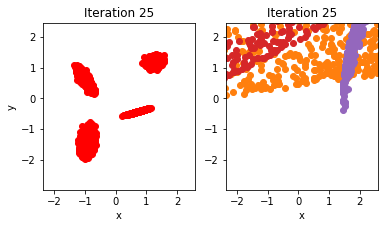

  2%|▏         | 49/2000 [10:23<14:15,  2.28it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.4301556492523735


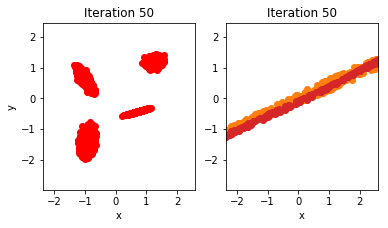

  4%|▎         | 74/2000 [10:42<13:48,  2.33it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.5355790071065868


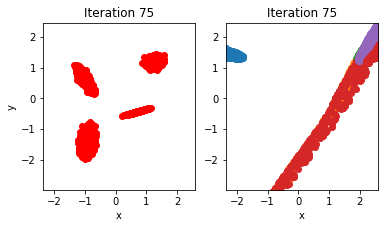

  5%|▍         | 99/2000 [11:01<13:37,  2.32it/s]

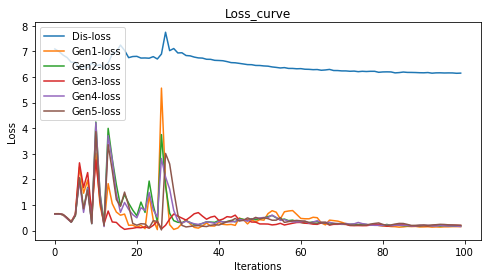

Running GMM on sample data
Fake number of clusters (AIC Estimate): 13
JS div 0.47008854705946346


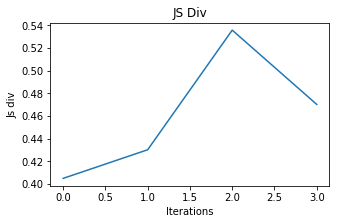

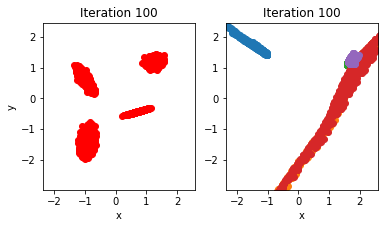

  6%|▌         | 124/2000 [11:23<13:16,  2.35it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 15
JS div 0.4605826854125274


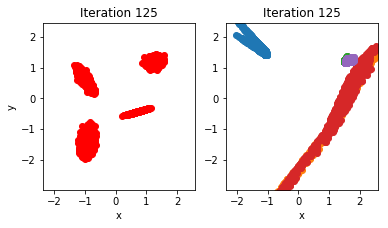

  7%|▋         | 149/2000 [11:40<12:54,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 14
JS div 0.4313406014776443


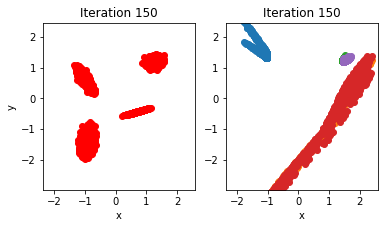

  9%|▊         | 174/2000 [11:58<12:40,  2.40it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.40816434124776635


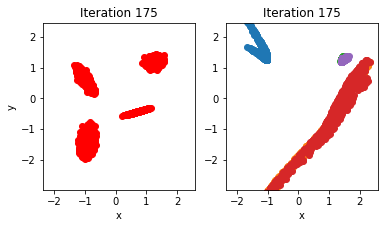

 10%|▉         | 199/2000 [12:16<12:32,  2.39it/s]

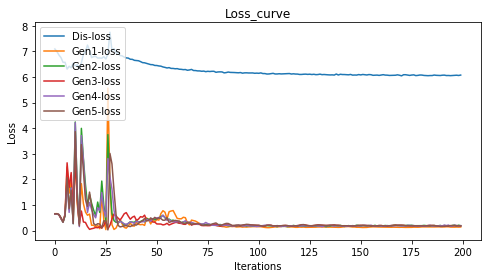

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.39086340555254184


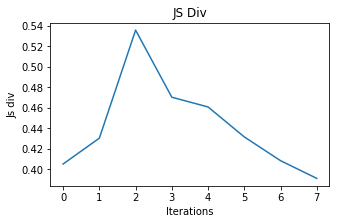

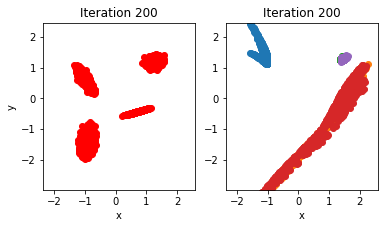

 11%|█         | 224/2000 [12:36<12:46,  2.32it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.3623722601096896


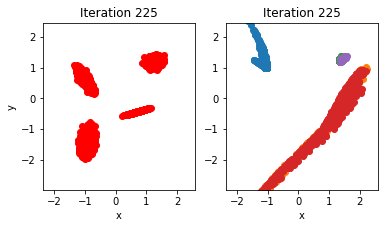

 12%|█▏        | 249/2000 [12:55<12:22,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.3403505207023094


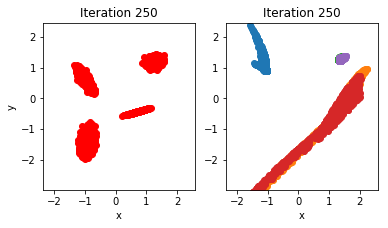

 14%|█▎        | 274/2000 [13:13<12:19,  2.33it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.32301269259458815


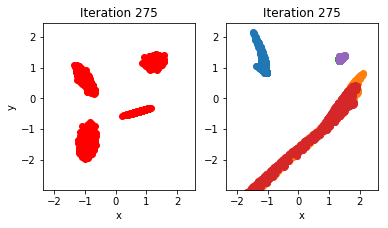

 15%|█▍        | 299/2000 [13:31<11:53,  2.38it/s]

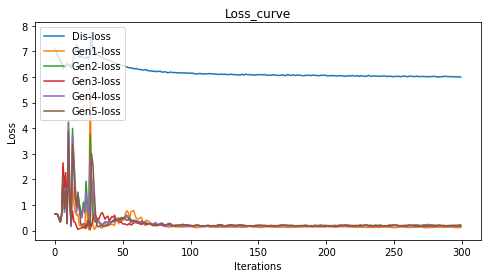

Running GMM on sample data
Fake number of clusters (AIC Estimate): 14
JS div 0.2979855437175815


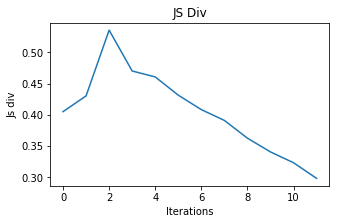

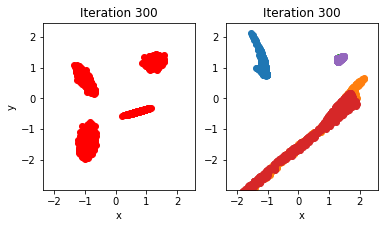

 16%|█▌        | 324/2000 [13:50<11:50,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.27429729719106866


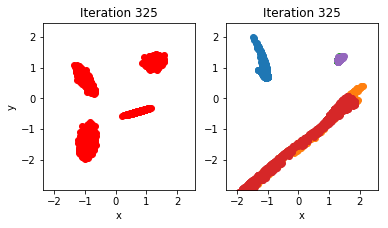

 17%|█▋        | 349/2000 [14:09<11:30,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.2544582385249347


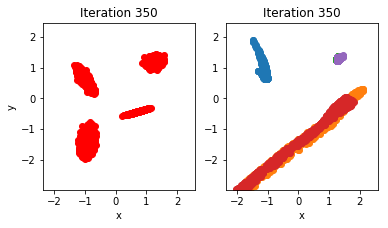

 19%|█▊        | 374/2000 [14:28<11:41,  2.32it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.233224290659437


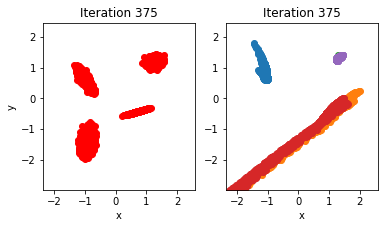

 20%|█▉        | 399/2000 [14:46<11:29,  2.32it/s]

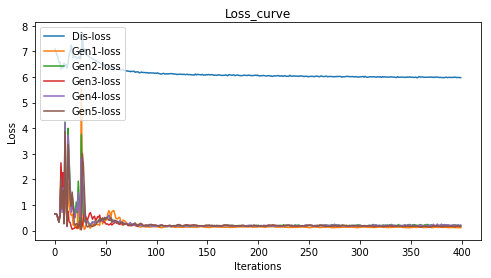

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.21918840388481636


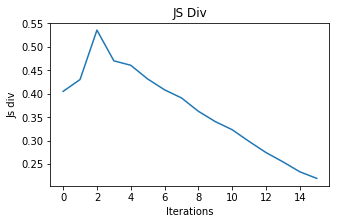

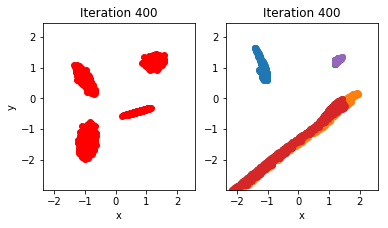

 21%|██        | 424/2000 [15:06<13:08,  2.00it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.21296475287380054


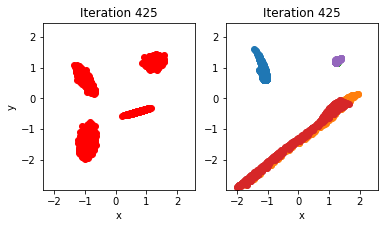

 22%|██▏       | 449/2000 [15:26<10:51,  2.38it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.19263251104589135


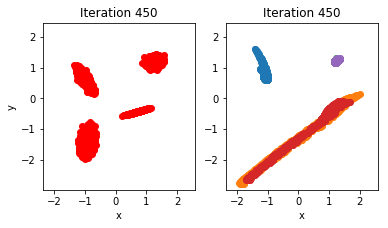

 24%|██▎       | 474/2000 [15:44<10:45,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.19099750776023994


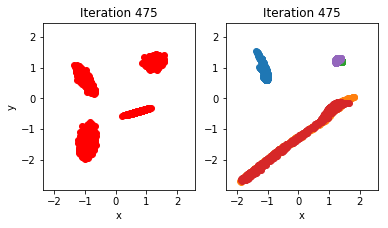

 25%|██▍       | 499/2000 [16:03<12:46,  1.96it/s]

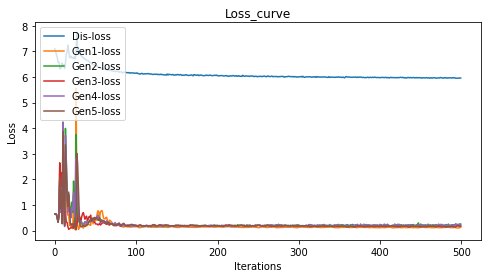

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.1925485879067439


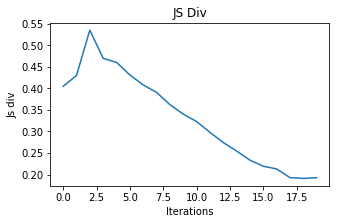

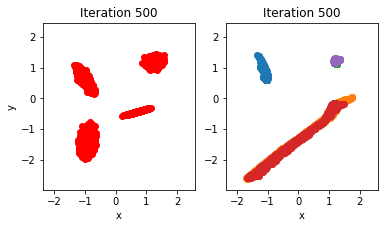

 26%|██▌       | 524/2000 [16:23<10:22,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.15679683114562065


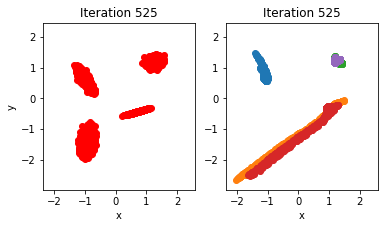

 27%|██▋       | 549/2000 [16:42<10:05,  2.40it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.1342473830303943


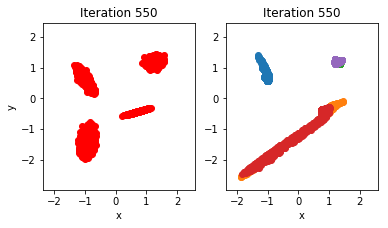

 29%|██▊       | 574/2000 [17:00<09:57,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.1230959432750428


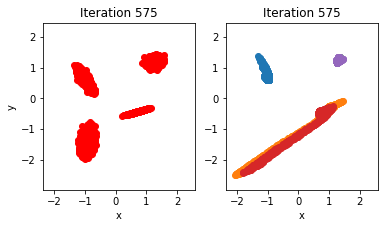

 30%|██▉       | 599/2000 [17:19<09:48,  2.38it/s]

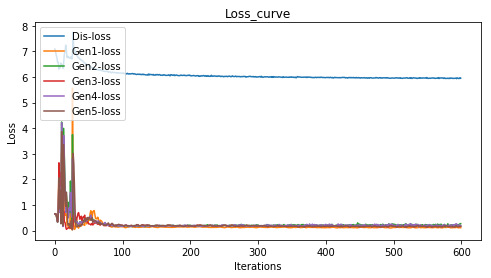

Running GMM on sample data
Fake number of clusters (AIC Estimate): 15
JS div 0.1404709981727384


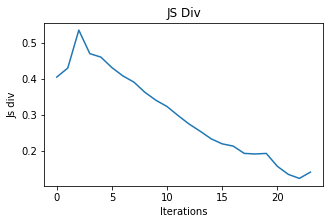

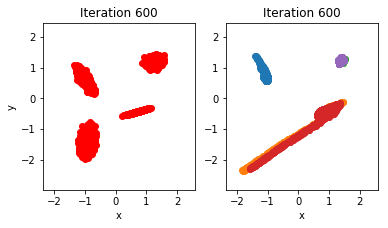

 31%|███       | 624/2000 [17:39<09:36,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.11390729927247581


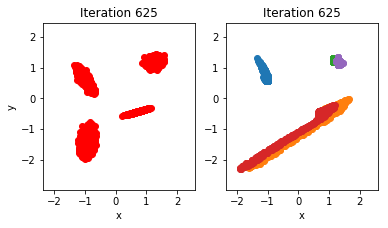

 32%|███▏      | 649/2000 [17:58<09:19,  2.41it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.10401906795505991


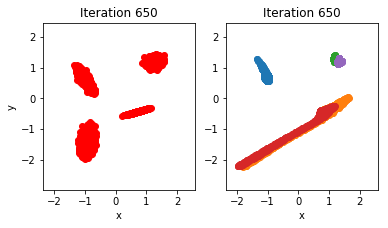

 34%|███▎      | 674/2000 [18:18<09:15,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.09652977969542434


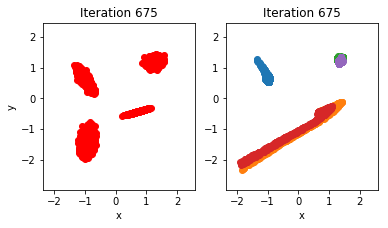

 35%|███▍      | 699/2000 [18:37<09:07,  2.37it/s]

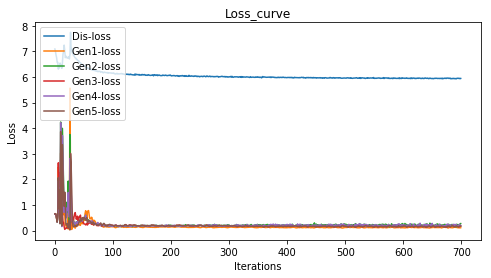

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.09225123511289202


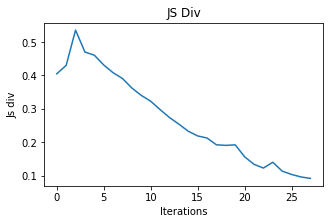

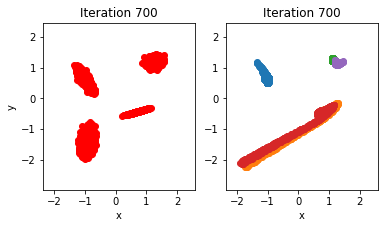

 36%|███▌      | 724/2000 [18:56<08:56,  2.38it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.09116068371804735


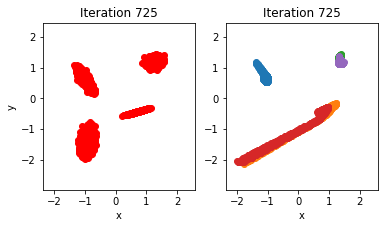

 37%|███▋      | 749/2000 [19:16<08:47,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.08132337173296186


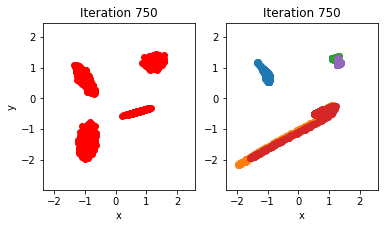

 39%|███▊      | 774/2000 [19:34<08:43,  2.34it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.07871729651542758


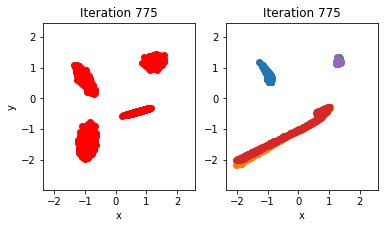

 40%|███▉      | 799/2000 [19:53<08:28,  2.36it/s]

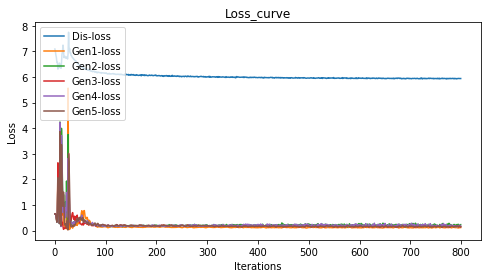

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.0766524080924942


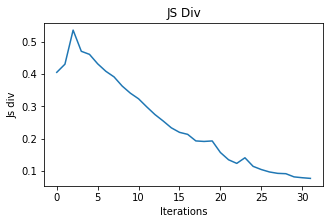

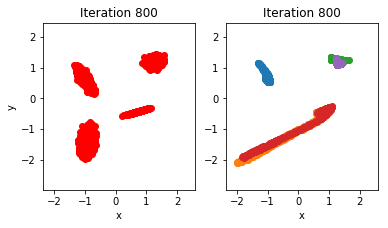

 41%|████      | 824/2000 [20:15<08:18,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.0880138883737137


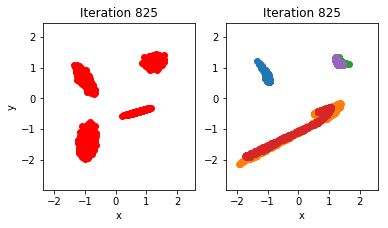

 42%|████▏     | 849/2000 [20:33<08:06,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.09395182473816346


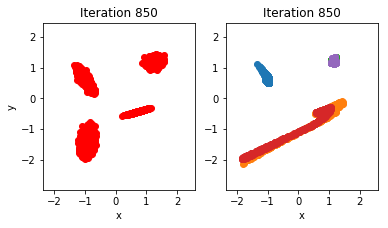

 44%|████▎     | 874/2000 [20:52<07:50,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.07788796325337789


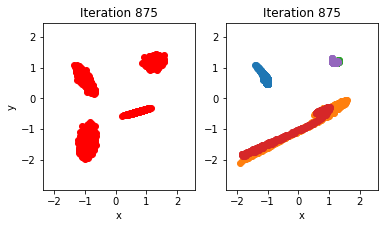

 45%|████▍     | 899/2000 [21:11<08:24,  2.18it/s]

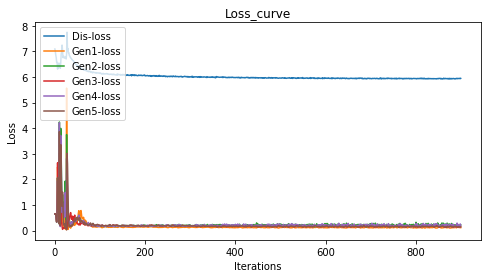

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.07448143125660464


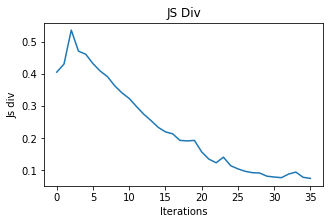

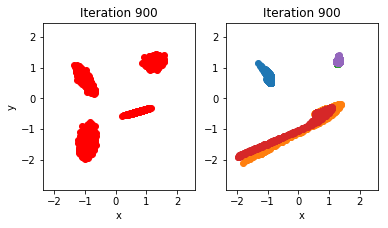

 46%|████▌     | 924/2000 [21:31<07:29,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.07473181843112514


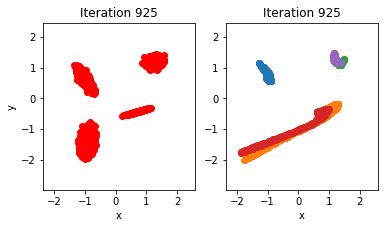

 47%|████▋     | 949/2000 [21:52<07:25,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.0857361076389527


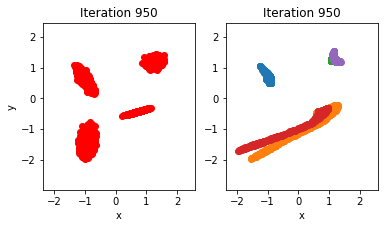

 49%|████▊     | 974/2000 [22:13<07:17,  2.35it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.06933396813583487


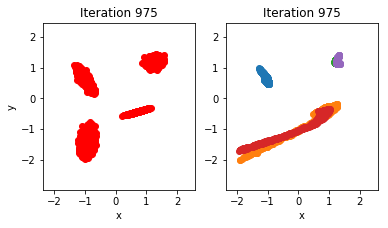

 50%|████▉     | 999/2000 [22:33<07:02,  2.37it/s]

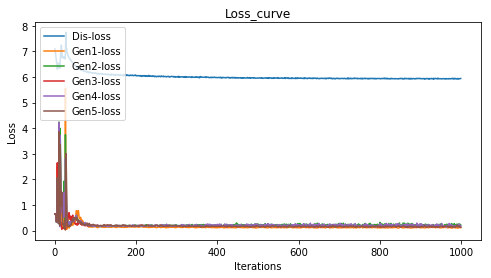

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.06633013943714805


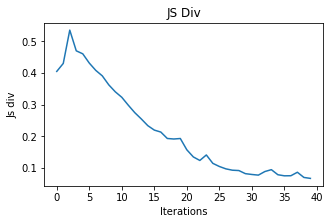

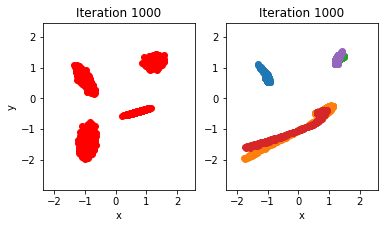

 51%|█████     | 1024/2000 [22:54<06:51,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.06875751824127888


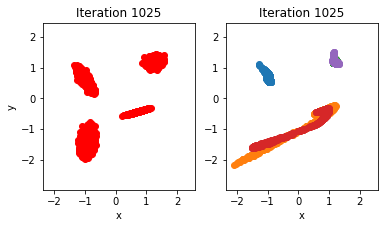

 52%|█████▏    | 1049/2000 [23:14<07:16,  2.18it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 15
JS div 0.06603555332358099


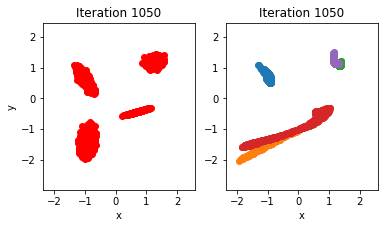

 54%|█████▎    | 1074/2000 [23:35<06:33,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.058981082105968016


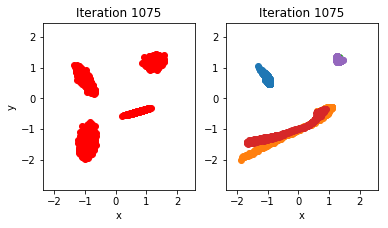

 55%|█████▍    | 1099/2000 [23:53<06:21,  2.36it/s]

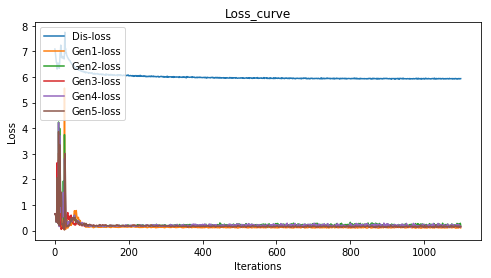

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.06681105009864058


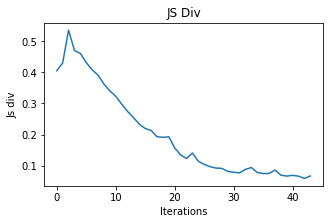

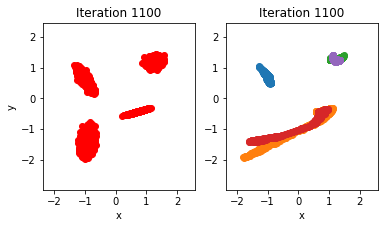

 56%|█████▌    | 1124/2000 [24:13<06:05,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.0698556030873921


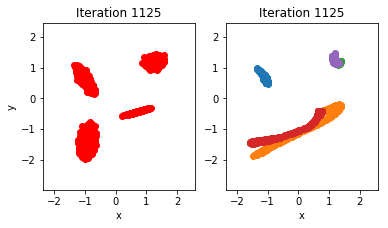

 57%|█████▋    | 1149/2000 [24:34<05:58,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.06353036369019667


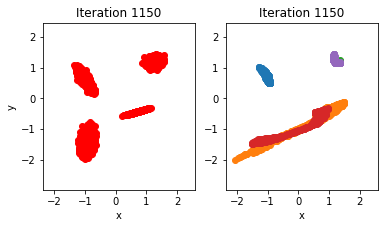

 59%|█████▊    | 1174/2000 [24:54<05:50,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.059408424675555294


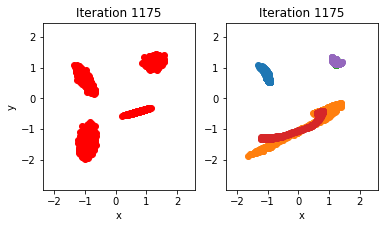

 60%|█████▉    | 1199/2000 [25:16<05:35,  2.39it/s]

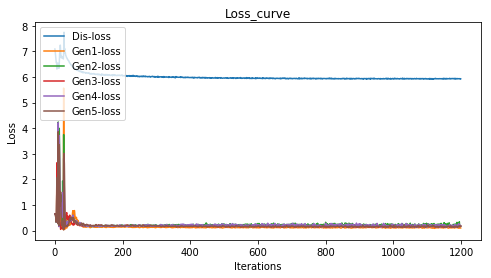

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.04922061129272325


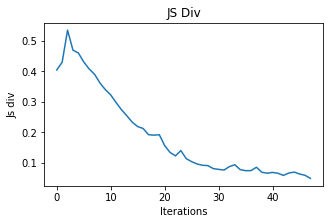

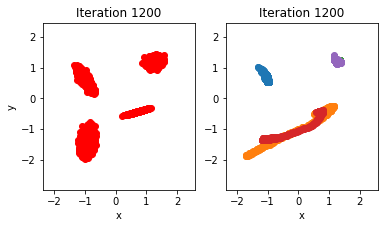

 61%|██████    | 1224/2000 [25:34<05:24,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.060595216042507206


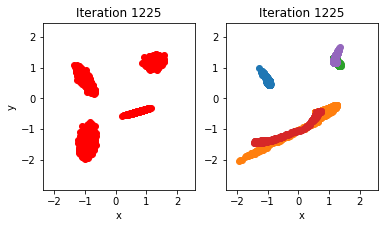

 62%|██████▏   | 1249/2000 [25:54<05:14,  2.38it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.04785943569814117


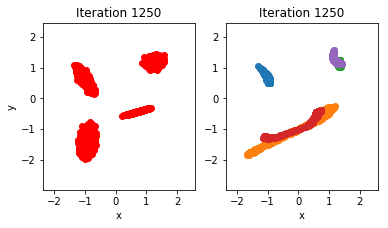

 64%|██████▎   | 1274/2000 [26:14<05:28,  2.21it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.06040843221865061


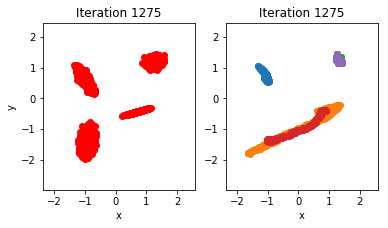

 65%|██████▍   | 1299/2000 [26:35<04:58,  2.35it/s]

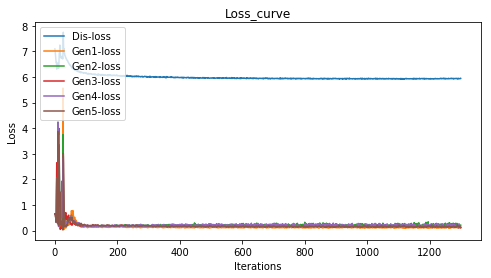

Running GMM on sample data
Fake number of clusters (AIC Estimate): 15
JS div 0.06688096951086075


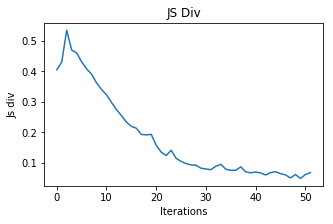

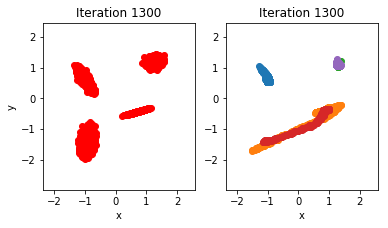

 66%|██████▌   | 1324/2000 [26:53<04:46,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.05296967878874197


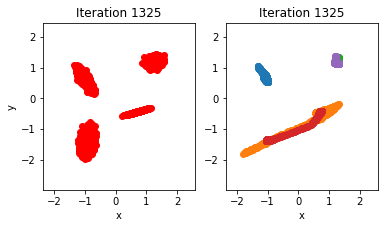

 67%|██████▋   | 1349/2000 [27:13<04:32,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.05019880316739502


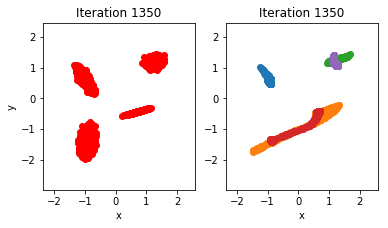

 69%|██████▊   | 1374/2000 [27:32<04:20,  2.40it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.05977597964550185


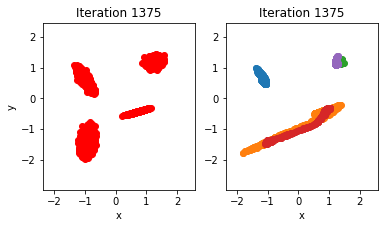

 70%|██████▉   | 1399/2000 [27:53<04:12,  2.38it/s]

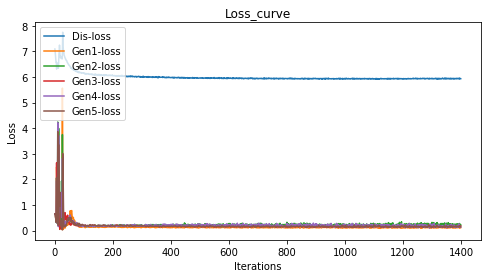

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.053969887530878335


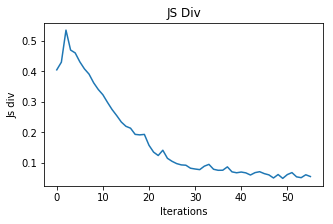

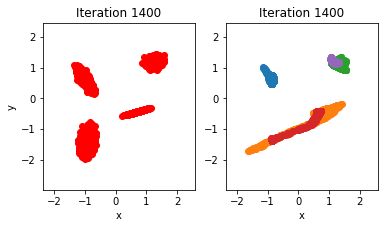

 71%|███████   | 1424/2000 [28:13<04:02,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.05603362802841972


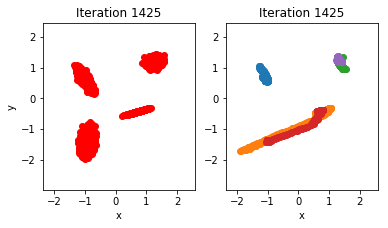

 72%|███████▏  | 1449/2000 [28:34<03:52,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.061541311929174815


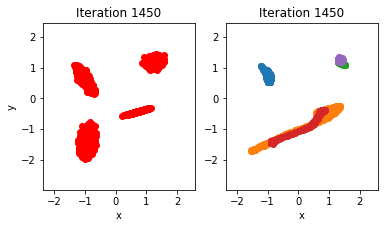

 74%|███████▎  | 1474/2000 [28:53<03:39,  2.39it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.05863153400598721


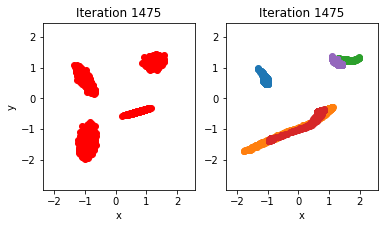

 75%|███████▍  | 1499/2000 [29:13<03:31,  2.37it/s]

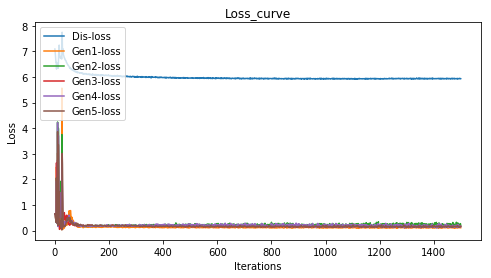

Running GMM on sample data
Fake number of clusters (AIC Estimate): 15
JS div 0.04615451348678033


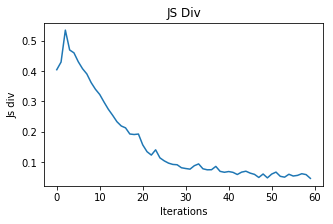

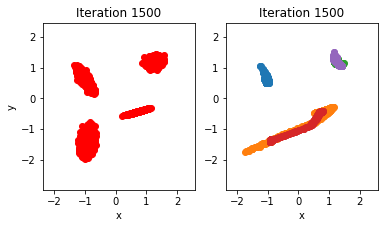

 76%|███████▌  | 1524/2000 [29:35<03:38,  2.18it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.047919285162604144


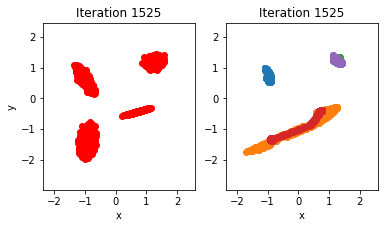

 77%|███████▋  | 1549/2000 [29:55<03:14,  2.32it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.04819003338662054


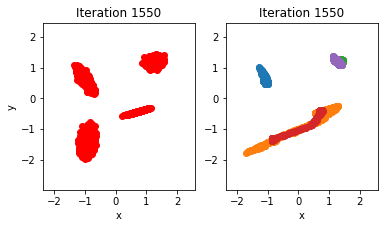

 79%|███████▊  | 1574/2000 [30:16<03:00,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.05154023624680346


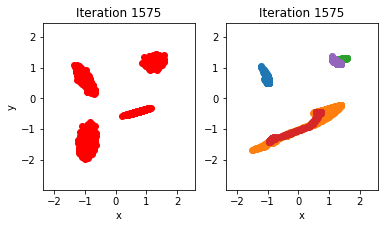

 80%|███████▉  | 1599/2000 [30:36<02:50,  2.35it/s]

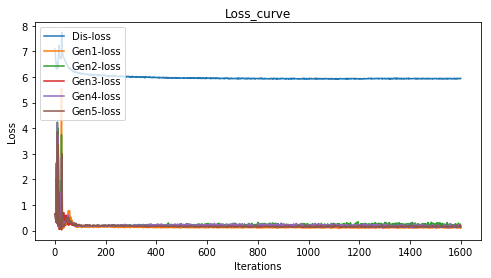

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.053240168411078675


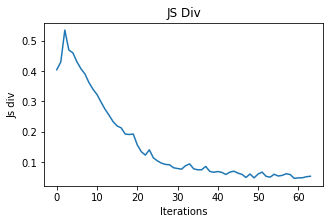

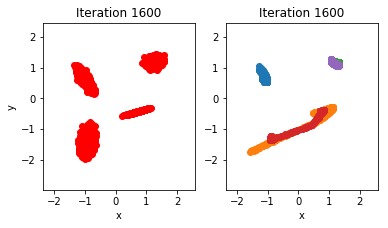

 81%|████████  | 1624/2000 [30:59<02:37,  2.38it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.047665007530682826


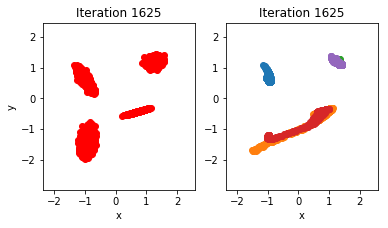

 82%|████████▏ | 1649/2000 [31:20<02:35,  2.26it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.04566588109064948


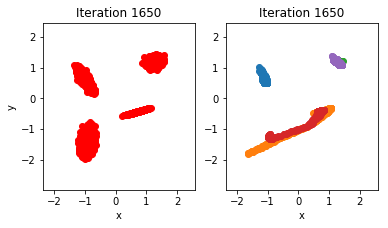

 84%|████████▎ | 1674/2000 [31:44<02:25,  2.23it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.05111769600986773


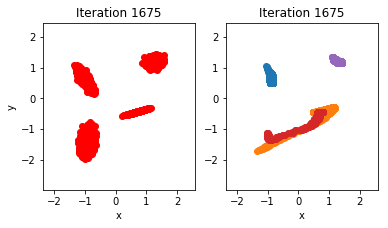

 85%|████████▍ | 1699/2000 [32:04<02:06,  2.37it/s]

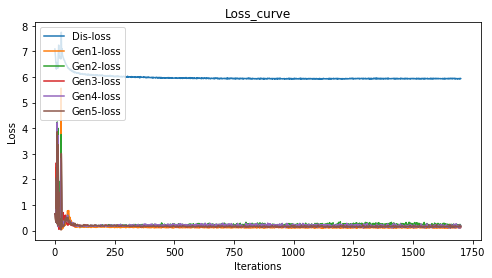

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.043728900957215815


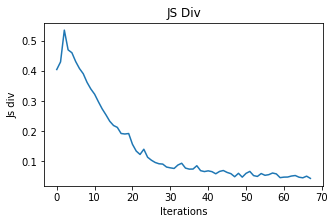

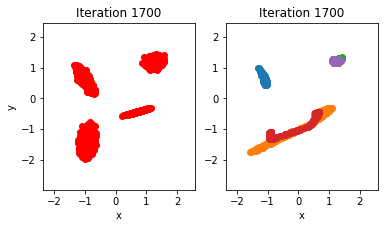

 86%|████████▌ | 1724/2000 [32:26<01:56,  2.38it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.04742167735553481


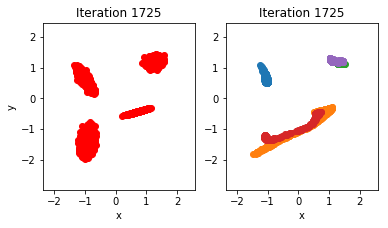

 87%|████████▋ | 1749/2000 [32:47<01:46,  2.36it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.04676342160104859


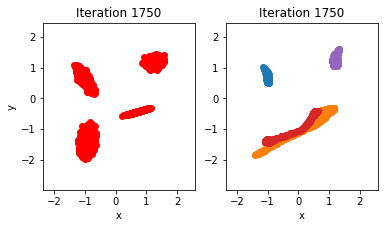

 89%|████████▊ | 1774/2000 [33:06<01:35,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.059256007767908944


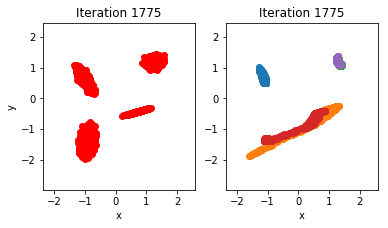

 90%|████████▉ | 1799/2000 [33:25<01:30,  2.23it/s]

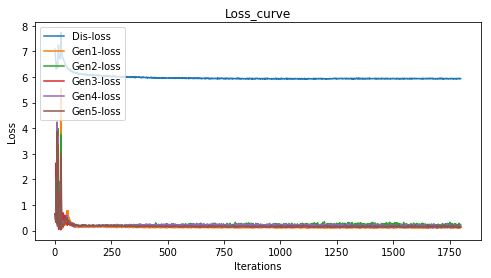

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.0384318718265242


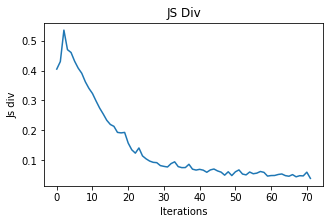

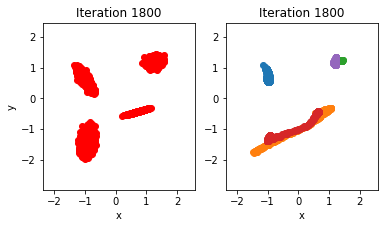

 91%|█████████ | 1824/2000 [33:47<01:14,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.04917268686042611


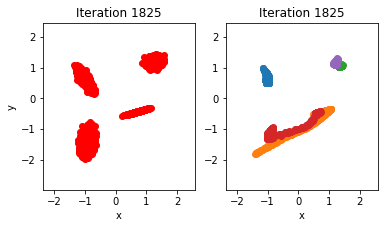

 92%|█████████▏| 1849/2000 [34:05<01:03,  2.38it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.05138408802616654


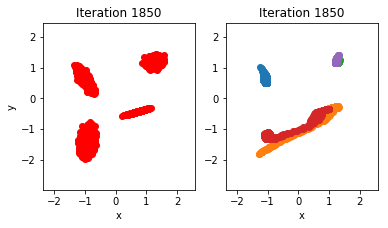

 94%|█████████▎| 1874/2000 [34:23<00:53,  2.37it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.052874563795647034


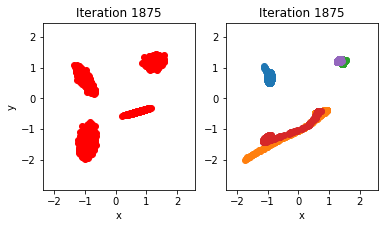

 95%|█████████▍| 1899/2000 [34:43<00:43,  2.33it/s]

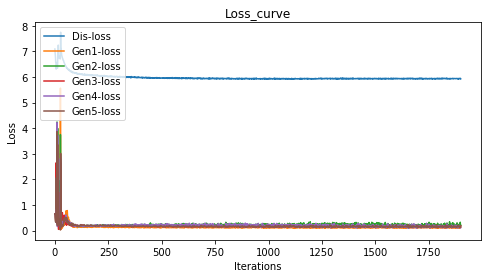

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.05167509915761416


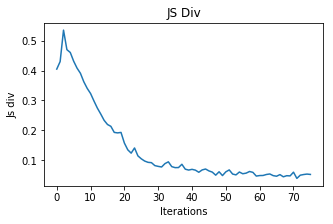

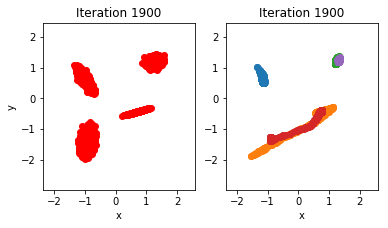

 96%|█████████▌| 1924/2000 [35:04<00:32,  2.35it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.053980908727998225


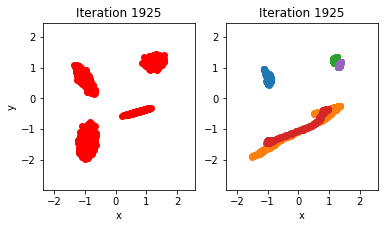

 97%|█████████▋| 1949/2000 [35:23<00:21,  2.38it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 17
JS div 0.05712471988977482


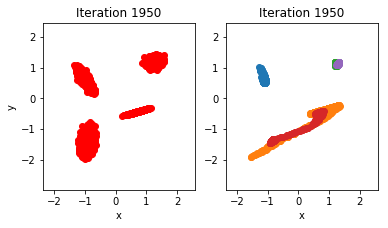

 99%|█████████▊| 1974/2000 [35:42<00:11,  2.35it/s]

Running GMM on sample data
Fake number of clusters (AIC Estimate): 18
JS div 0.0556502035123336


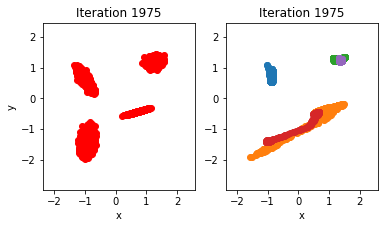

100%|█████████▉| 1999/2000 [36:00<00:00,  2.40it/s]

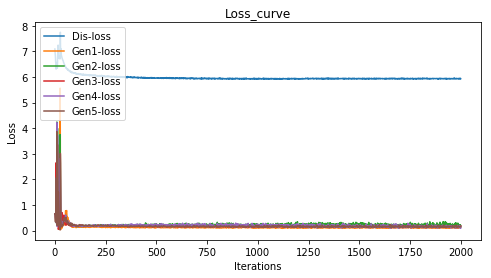

Running GMM on sample data
Fake number of clusters (AIC Estimate): 16
JS div 0.047201342526065754


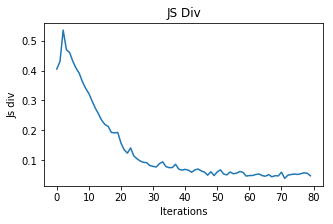

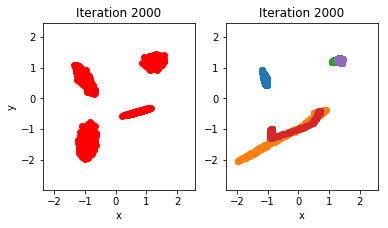

100%|██████████| 2000/2000 [36:11<00:00,  1.09s/it]


In [10]:
print("Iteration starts")
for iteration in tqdm(range(0,iterations)):
# for iteration in range(0,iterations):
    learning_rate = base_lr * np.exp(-lr_decay * min(1.0, (iteration*batch_size)/float(syn_data.N)))
    batch_z = np.random.uniform(-1, 1, [batch_size, z_dim])
    input_batch = syn_data.next_batch(batch_size)
    _, d_loss = session.run([bgan.d_optim, bgan.d_loss], feed_dict={bgan.inputs: input_batch, bgan.z: batch_z, bgan.d_learning_rate: learning_rate})

    g_losses = []
    for g in range(0, bgan.num_gen): # compute g_sample loss
        batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]) ## redundant
        _, g_loss = session.run([bgan.g_optims[g], bgan.generation["g_losses"][g]], feed_dict={bgan.z: batch_z, bgan.g_learning_rate: learning_rate})
        g_losses.append(g_loss)
        
#     print("Disc loss = %.2f" % d_loss, ", Gen loss = ", ", ".join(["%.2f" % gl for gl in g_losses])) 
    dis_loss.append(d_loss)
    for i,loss in enumerate(g_losses, start=1):
        gen_loss[i].append(loss)

    if (iteration + 1) % 25 == 0:
        if (iteration + 1) % 100 == 0:
            labels = []
            plt.figure(figsize=(8,4))
            plt.title('Loss_curve')
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.plot(dis_loss)
            labels.append('Dis-loss')
            for key,value in gen_loss.items():
                plt.plot(value)
                labels.append('Gen'+str(key)+'-loss')
            plt.legend(labels, loc='upper left')
            plt.savefig(results_path+'loss'+str(iteration)+'.png')
            plt.show()
        
        print("Running GMM on sample data")
        generated_data = []
        fake_data = defaultdict(list) ##generating data from the distribution
        for num_samples in range(0, 10):
            for g in range(0, bgan.num_gen):
                # collect sample
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) ## redundant
                sampled_data = session.run(bgan.generation["gen_samplers"][g], feed_dict={bgan.z: sample_z})
                fake_data[g].append(sampled_data)
                generated_data.append(sampled_data)
                
        X_real = syn_data.X
        X_sample = np.concatenate(generated_data)
        for g in range(0, bgan.num_gen):
            fake_data[g] = np.concatenate(fake_data[g]) ##why np.concatenate
        all_data_fake.append(X_sample)
        
        aics_fake = gmm_ms(X_sample)
        all_aics_fake.append(aics_fake)
        print("Fake number of clusters (AIC Estimate):", aics_fake.argmin())
        
        div, X_trans_real, X_trans_fake = analyze_div(X_real, X_sample)
        all_div.append(div)
        print("JS div", div) 
        
        if (iteration + 1) % 100 == 0:
            plt.figure(figsize=(5,3))
            plt.title('JS Div')
            plt.xlabel('Iterations')
            plt.ylabel('Js div')
            plt.plot(all_div)
            plt.savefig(results_path+'div'+str(iteration)+'.png')
            plt.show()
        
        fig, ax_arr = plt.subplots(1,2)
        xmin1 = np.min(X_trans_real[:, 0]) - 1.0
        xmax1 = np.max(X_trans_real[:, 0]) + 1.0
        xmin2 = np.min(X_trans_real[:, 1]) - 1.0
        xmax2 = np.max(X_trans_real[:, 1]) + 1.0
        ax_arr[0].scatter(X_trans_real[:, 0], X_trans_real[:, 1], c='r')
        ax_arr[0].set_xlim([xmin1, xmax1]); ax_arr[0].set_ylim([xmin2, xmax2])
        for g in range(0, bgan.num_gen):
            ax_arr[1].scatter(fake_data[g][:, 0], fake_data[g][:, 1])
        ax_arr[1].set_xlim([xmin1, xmax1]); ax_arr[1].set_ylim([xmin2, xmax2])
        ax_arr[0].set_aspect('equal', adjustable='box')
        ax_arr[1].set_aspect('equal', adjustable='box')
        ax_arr[0].set_title("Iteration %i" % (iteration+1))
        ax_arr[1].set_title("Iteration %i" % (iteration+1))
        ax_arr[0].set_xlabel('x')
        ax_arr[1].set_xlabel('x')
        ax_arr[0].set_ylabel('y')
#         ax_arr[1].set_ylabel('y')
        plt.savefig(results_path+'data'+str(iteration)+'.png')
        plt.show()